## Do US Movies with Longer Running Times Tend to get Higher Ratings on IMDB?
***
- Data for this analysis comes from https://datasets.imdbws.com/
- Data descriptions can be found here: https://www.imdb.com/interfaces/
- Filters that will be applied to data:
    - Data will be limited to the United States region
    - Data will not include adult films
    - Data will be limited to title types of "movie"
    - Data will only include films with a release year between 2010 and 2020, inclusive


###  1.  Import titles.tsv dataset 
- Only include records with region type of "US"
- Drop "ordering" column
- Remove duplicate rows

In [2]:
import pandas as pd
import thinkstats2
import thinkplot


df = pd.read_csv('data/titles.tsv', sep='\t', dtype={'titleId':str, 'title':str})
us_df = df[df["region"]=="US"]
us_df = df.drop(columns=['ordering'])
us_df.sort_values("titleId", inplace=True)
us_df.drop_duplicates(subset ="titleId",
                     keep = False, inplace = True)

us_df.head(5)


C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,titleId,title,region,language,types,attributes,isOriginalTitle
1030,tt0000251,Matches: An Appeal,GB,\N,\N,\N,0
6689,tt0002276,De industrieel van Pont Avesnes,NL,\N,\N,\N,0
6862,tt0002345,Marocco en het Vreemdelingenlegioen,NL,\N,\N,\N,0
7357,tt0002517,Talma,NL,\N,\N,\N,0
8177,tt0002832,Evangeline,CA,\N,\N,\N,0


### 2. Import titleRatings.tsv dataset 
- Re-name columns

In [3]:
rate_df = pd.read_csv('data/titleratings.tsv', sep='\t')
rate_df.columns = ['titleId', 'averageRating', 'numVotes']
rate_df.head(5)

,titleId,averageRating,numVotes
0,tt0000001,5.7,1785
1,tt0000002,6.0,230
2,tt0000003,6.5,1541
3,tt0000004,6.1,150
4,tt0000005,6.2,2361


### 3. Import titleBasics.tsv dataset 
- Remove records that are adult films
- Only include records with titleType of movie
- Drop columns: isAdult, endYear, & originalTitle

In [4]:
names_df = pd.read_csv('data/titleBasics.tsv', sep='\t')

names_df = names_df[names_df["isAdult"]!="1"]
names_df = names_df[names_df["titleType"]=="movie"]

names_df = names_df.drop(columns=['isAdult', 'endYear','originalTitle'])
names_df.columns = ['titleId','titleType', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres']


C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 4. Check Record Count of all data sets
- This will be used to ensure join in next section works correctly

In [5]:
print("Title Row Count:  "+str(len(us_df)))
print("Ratings Row Count: "+str(len(rate_df)))
print("Title Detail Row Count: "+str(len(names_df)))

Title Row Count:  1139940
Ratings Row Count: 1179054
Title Detail Row Count: 584673


### 5. Join Datasets 
- Set indexes of names_df and us_df to titleId and join on titleId
- Set df_merge to output of joined us_df and us_df
- Set index of rate_df to titleId and join to df_merge on titleID
- Set df_merge to output of joined df_merge and rate_df
- Remove all records from df_merge that do not have region of "US" and set output to df_merge
- Remove all instances of the value '\N' from df_merge and replace with blanks


In [6]:
df_merge = names_df.set_index('titleId').join(us_df.set_index('titleId'))
df_merge = df_merge.join(rate_df.set_index('titleId'))
df_merge = df_merge[df_merge["region"]=="US"]
df_merge.replace(to_replace=r"\\N", value='', regex=True, inplace=True)

### 6. Clean Up Data: Check Data Types of Variables 

In [7]:
df_merge.dtypes

titleType           object
primaryTitle        object
startYear           object
runtimeMinutes      object
genres              object
title               object
region              object
language            object
types               object
attributes          object
isOriginalTitle     object
averageRating      float64
numVotes           float64
dtype: object

### 6.1 Clean Up Data: Convert Variable Data Types
- Convert following fields to data type of numeric
    - startYear
    - runtimeMinutes
    - averageRating
    - numVotes

In [8]:
df_merge["startYear"] = pd.to_numeric(df_merge["startYear"])
df_merge["runtimeMinutes"] = pd.to_numeric(df_merge["runtimeMinutes"])
df_merge["averageRating"] = pd.to_numeric(df_merge["averageRating"])
df_merge["numVotes"] = pd.to_numeric(df_merge["numVotes"])


### 6.2 Clean Up Data: Break up comma-separated 'genres' column into 3 separate columns for ease-of-use

- 3 new columns will be created:
    - genre_1
    - genre_2
    - genre_3
- Print Column names

In [9]:
df_merge_split = df_merge['genres'].str.split(',', expand=True)
df_merge_split.columns = ['genre_'+str(i+1) for i in df_merge_split.columns]
df_merge = pd.concat([df_merge,df_merge_split], axis=1)
for col in df_merge.columns:
    print(col)

titleType
primaryTitle
startYear
runtimeMinutes
genres
title
region
language
types
attributes
isOriginalTitle
averageRating
numVotes
genre_1
genre_2
genre_3


### 6.3 Clean Up Data: Remove Unneccessary Columns from Dataframe
- Columns that will be dropped:
    - titleType
    - genres
    - region
    - language
    - types
    - attributes
    - isOriginalTitle
- Print Column names
    

In [10]:
df_merge = df_merge.drop(columns=[ 'titleType','genres','region',
                                  'language', 'types', 'attributes',
                                 'isOriginalTitle'])
for col in df_merge.columns:
    print(col)

primaryTitle
startYear
runtimeMinutes
title
averageRating
numVotes
genre_1
genre_2
genre_3


### 6.4 Clean Up Data: Identify records with NaN value for averageRating or runtimeMinutes

In [11]:
print(df_merge['runtimeMinutes'].isnull().sum())
print(df_merge['averageRating'].isnull().sum())

24278
30806


### 6.5 Clean Up Data: Remove records with NaN for averageRating or runtimeMinutes

In [12]:
print(len(df_merge))
df_merge.dropna(subset = ["runtimeMinutes"], inplace=True)
print(len(df_merge))
df_merge.dropna(subset = ["averageRating"], inplace=True)
print(len(df_merge))

32878
8600
1762


### 7. Data Analysis: Analysis of startYear Variable
 - Build and show frequency distribution histogram of startYear variable
 - Histogram shows left-skew

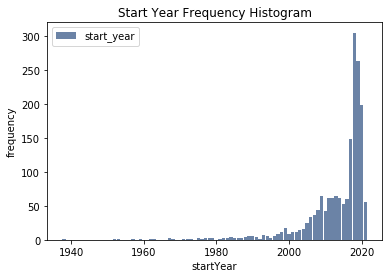

<Figure size 576x432 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

plt.title("Start Year Frequency Histogram")
hist = thinkstats2.Hist(df_merge.startYear,label='start_year')
thinkplot.Hist(hist)
thinkplot.Show(xlabel='startYear', ylabel='frequency')

### 7.1 Data Analysis: Analysis of startYear Variable
 - The dataframe is limited to only records with startYear values between 2010 and 2020, inclusive
 - The new dataframe is plotted in the frequency distributuion histogram below for the startYear variable
 - This will be the data used in the final analysis, as it removes all outliers

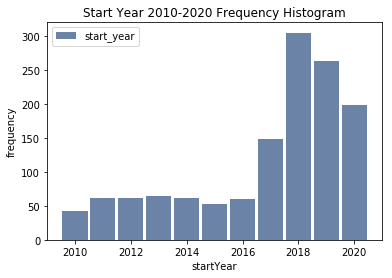

<Figure size 576x432 with 0 Axes>

In [17]:
#Filter out movies not yet released in 2021 and forward
df_merge= df_merge[df_merge["startYear"]<=2020]
df_merge= df_merge[df_merge["startYear"]>=2010]
plt.title("Start Year 2010-2020 Frequency Histogram")
hist = thinkstats2.Hist(df_merge.startYear,label='start_year')
thinkplot.Hist(hist)
thinkplot.Show(xlabel='startYear', ylabel='frequency')

###  8. Data Analysis: Analysis of genre_1 Variable
- The genre_1 variable is the first value from the orignal 'genres' variable. (The 'genres' variable contained up to 3 comma-separated values for each record)
- The below is the frequency bar chart of this variable

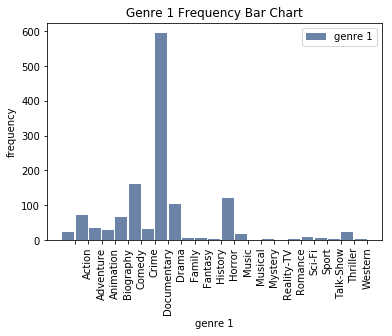

<Figure size 576x432 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
plt.xticks(rotation=90)
hist = thinkstats2.Hist(df_merge.genre_1,label='genre 1')
plt.title("Genre 1 Frequency Bar Chart")
thinkplot.Hist(hist)
thinkplot.Show(xlabel='genre 1', ylabel='frequency')

###  9. Data Analysis: Analysis of genre_2 Variable
- The genre_2 variable is the second value from the orignal 'genres' variable. (The 'genres' variable contained up to 3 comma-separated values for each record)
- The below is the frequency bar chart of this variable

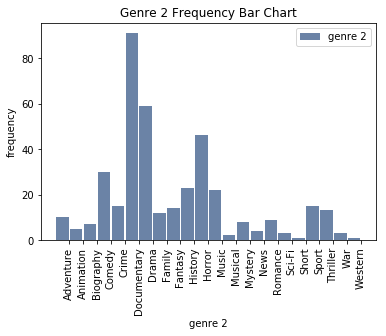

<Figure size 576x432 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
plt.xticks(rotation=90)
hist = thinkstats2.Hist(df_merge.genre_2,label='genre 2')
plt.title("Genre 2 Frequency Bar Chart")
thinkplot.Hist(hist)
thinkplot.Show(xlabel='genre 2', ylabel='frequency')

###  10. Data Analysis: Analysis of genre_3 Variable
- The genre_3 variable is the third value from the orignal 'genres' variable. (The 'genres' variable contained up to 3 comma-separated values for each record)
- The below is the frequency bar chart of this variable

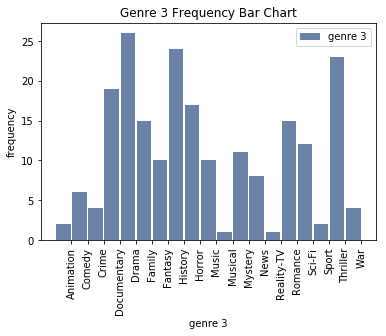

<Figure size 576x432 with 0 Axes>

In [22]:
plt.xticks(rotation=90)
hist = thinkstats2.Hist(df_merge.genre_3,label='genre 3')
plt.title("Genre 3 Frequency Bar Chart")
thinkplot.Hist(hist)
thinkplot.Show(xlabel='genre 3', ylabel='frequency')

### 11. Data Analysis: Analysis of runtimeMinutes variable
- The below is a frequency distribution histogram for the runtimeMinutes variable
- The histogram is right-skewed

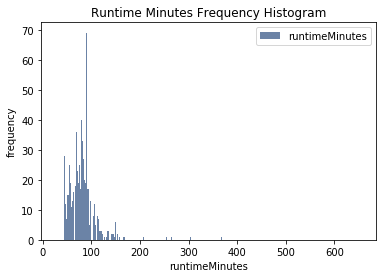

<Figure size 576x432 with 0 Axes>

In [23]:
hist = thinkstats2.Hist(df_merge.runtimeMinutes,label='runtimeMinutes')
plt.title("Runtime Minutes Frequency Histogram")
thinkplot.Hist(hist)
thinkplot.Show(xlabel='runtimeMinutes', ylabel='frequency')

### 11.1 Data Analysis: Analysis of runtimeMinutes variable
- Below, the summary statistics are computed and printed for the runtimeMinutes variable


In [24]:
runTime_mode = df_merge.runtimeMinutes.mode()
runTime_var = df_merge.runtimeMinutes.var()
print("mode:" + str(runTime_mode))
print("spread:" + str(runTime_var))
df_merge.runtimeMinutes.describe()

mode:0    90.0
dtype: float64
spread:1048.2359862821995


count    1321.000000
mean       81.418622
std        32.376473
min        28.000000
25%        62.000000
50%        78.000000
75%        91.000000
max       653.000000
Name: runtimeMinutes, dtype: float64

### 12.  Data Analysis: Analysis of numVotes variable
- The below is a frequency distribution histogram for the numVotes variable
- The histogram is right-skewed

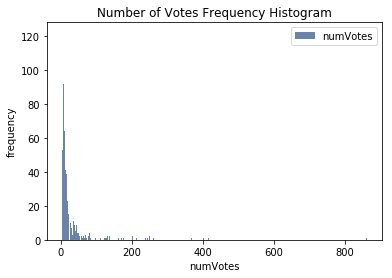

<Figure size 576x432 with 0 Axes>

In [25]:
hist = thinkstats2.Hist(df_merge.numVotes,label='numVotes')
plt.title("Number of Votes Frequency Histogram")
thinkplot.Hist(hist)
thinkplot.Show(xlabel='numVotes', ylabel='frequency')

### 12.1 Data Analysis: Analysis of numVotes variable
- Below, the summary statistics are computed and printed for the numVotes variable


In [26]:
numVotes_mode = df_merge.numVotes.mode()
numVotes_var = df_merge.numVotes.var()
print("mode:" + str(numVotes_mode))
print("spread:" + str(numVotes_var))
df_merge.numVotes.describe()

mode:0    6.0
dtype: float64
spread:3661.89946436356


count    1321.000000
mean       29.452687
std        60.513630
min         5.000000
25%         8.000000
50%        13.000000
75%        25.000000
max       862.000000
Name: numVotes, dtype: float64

### 13.  Data Analysis: Analysis of averageRating variable
- The below is a frequency distribution histogram for the averageRating variable
- The histogram is slightly left-skewed
- There are many values for ratings and I will want to group these to perform more analysis. This will be done in step 13.2

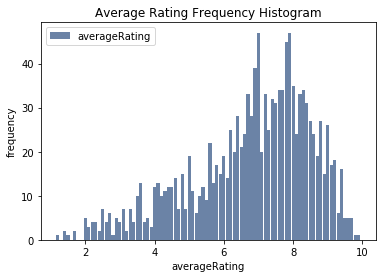

<Figure size 576x432 with 0 Axes>

In [27]:
hist = thinkstats2.Hist(df_merge.averageRating,label='averageRating')
thinkplot.Hist(hist)
plt.title("Average Rating Frequency Histogram")
thinkplot.Show(xlabel='averageRating', ylabel='frequency')

### 13.1 Data Analysis: Analysis of averageRating variable
- Below, the summary statistics are computed and printed for the averageRating variable


In [726]:
averageRating_mode = df_merge.averageRating.mode()
averageRating_var = df_merge.averageRating.var()
print("mode:" + str(averageRating_mode))
print("spread:" + str(averageRating_var))
df_merge.averageRating.describe()

mode:0    7.0
1    7.9
dtype: float64
spread:3.06394494528939


count    1321.000000
mean        6.790765
std         1.750413
min         1.200000
25%         5.800000
50%         7.100000
75%         8.100000
max         9.900000
Name: averageRating, dtype: float64

### 13.2 Data Analysis: Analysis of averageRatingGrpd variable
- Below, a new variable is created that groups ratings into smaller categories
    - Ratings between 0 & 0.5 are assigned to group 0.0
    - Ratings between 0.5 & 1 are assigned to group 0.5
    - ...
    - Ratings between 9.5 & 10 are assigned to group 9.5

In [32]:
x = 0.5
nmax = round(max(df_merge['averageRating']),2)
cut_bins = np.arange(0, nmax+x, 0.5).tolist()
bins = np.arange(0, nmax, 0.5).tolist()
df_merge['averageRatingGrpd'] = pd.cut(df_merge['averageRating'], bins=cut_bins, labels=bins)


### 13.3 Data Analysis: A new histogram is constructed with new grouped average rating variable

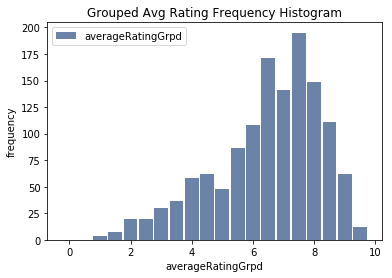

<Figure size 576x432 with 0 Axes>

In [33]:
hist = thinkstats2.Hist(df_merge.averageRatingGrpd,label='averageRatingGrpd')
plt.title("Grouped Avg Rating Frequency Histogram")
thinkplot.Hist(hist)
thinkplot.Show(xlabel='averageRatingGrpd', ylabel='frequency')

### 14. Probability Mass Function
- First step is to add indicators to break up records into 'shorter', 'longer', and 'regular'
- This is done by creating a new variable in the data that uses quartile ranges to categorize based on runtime
    - first quartile is categorized as 'shorter'
    - second & third quartile is categorized as 'regular'
    - fourth quartile is categorized as 'longer'
    
-Two new dataframes are created 


In [34]:
import numpy as np

df_merge['quantile_4'] = pd.qcut(df_merge['runtimeMinutes'], 4, labels=False)

df_merge['quantile_4'].replace(to_replace=0, value='shorter', regex=True, inplace=True)
df_merge['quantile_4'].replace(to_replace=1, value='regular', regex=True, inplace=True)
df_merge['quantile_4'].replace(to_replace=2, value='regular', regex=True, inplace=True)
df_merge['quantile_4'].replace(to_replace=3, value='longer', regex=True, inplace=True)

df_merge_longer = df_merge[df_merge['quantile_4'] == 'longer']
df_merge_other = df_merge[df_merge['quantile_4'] != 'longer']



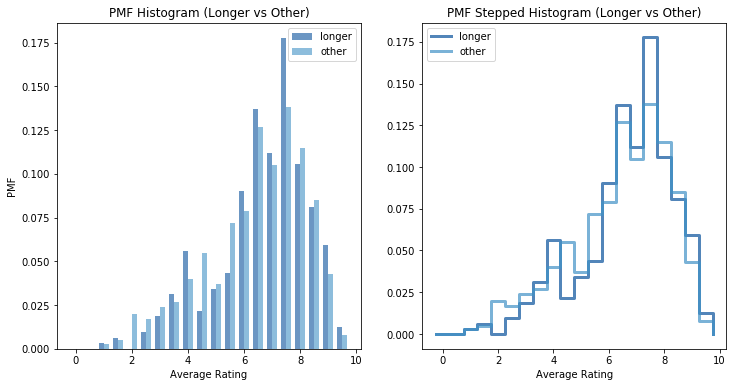

In [37]:
other_pmf= thinkstats2.Pmf(df_merge_other.averageRatingGrpd, label='other')
longer_pmf= thinkstats2.Pmf(df_merge_longer.averageRatingGrpd, label='longer')

width=0.18

plt.title("PMF Histogram (Longer vs Other)")
thinkplot.PrePlot(2, cols=2)
plt.title("PMF Histogram (Longer vs Other)")
thinkplot.Hist(longer_pmf, align='right', width=width)
thinkplot.Hist(other_pmf, align='left', width=width)
thinkplot.Config(xlabel='Average Rating', ylabel='PMF')


thinkplot.PrePlot(2)
thinkplot.SubPlot(2)
plt.title("PMF Stepped Histogram (Longer vs Other)")
thinkplot.Pmfs([longer_pmf, other_pmf])
thinkplot.Config(xlabel='Average Rating')



### 14.1 Difference in PMFs

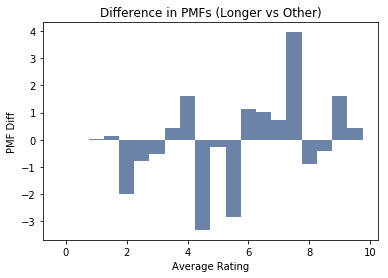

In [46]:
diffs = []
for i in bins:
    p1 = longer_pmf.Prob(i)
    p2 = other_pmf.Prob(i)
    diff = 100 * (p1 - p2)
    diffs.append(diff)

plt.title("Difference in PMFs (Longer vs Other)")
thinkplot.Bar(bins, diffs, width=0.5)
thinkplot.Config(xlabel='Average Rating', ylabel='PMF Diff')

### 15. Cumulative Distribution Function

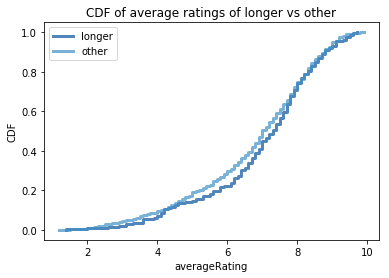

<Figure size 576x432 with 0 Axes>

In [45]:
longer_cdf = thinkstats2.Cdf(df_merge_longer.averageRating,
                             label = 'longer')
other_cdf = thinkstats2.Cdf(df_merge_other.averageRating,
                             label = 'other')
plt.title("CDF of average ratings of longer vs other")
thinkplot.PrePlot(2)
thinkplot.Cdfs([longer_cdf, other_cdf])
thinkplot.Show(xlabel='averageRating', ylabel='CDF')

### 15.1 Difference in CDFs

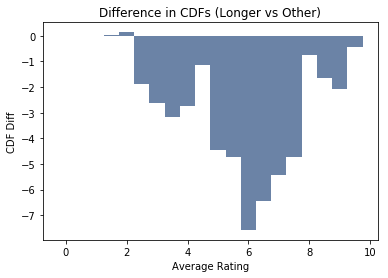

In [48]:
diffs = []
for i in bins:
    p1 = longer_cdf.Prob(i)
    p2 = other_cdf.Prob(i)
    diff = 100 * (p1 - p2)
    diffs.append(diff)

plt.title("Difference in CDFs (Longer vs Other)")
thinkplot.Bar(bins, diffs, width=0.5)
thinkplot.Config(xlabel='Average Rating', ylabel='CDF Diff')

### 16. Normal Probability Plot

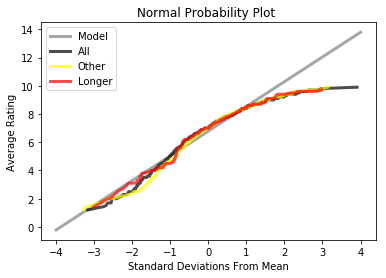

<Figure size 576x432 with 0 Axes>

In [50]:
def MakeNormalPlot(weights):
    mean = weights.mean()
    std = weights.std()
    
    xs = [-4, 4]
    fxs, fys = thinkstats2.FitLine(xs, inter=mean,slope = std)
    thinkplot.Plot(fxs, fys, color='gray', label='Model')
    
plt.title('Normal Probability Plot ')
plt.ylabel('Average Rating')
plt.xlabel('Standard Deviations From Mean')

MakeNormalPlot(df_merge.averageRating)

xs, ys = thinkstats2.NormalProbability(df_merge.averageRating)
thinkplot.Plot(xs, ys, label='All', color='black')

fxs, fys = thinkstats2.NormalProbability(df_merge_other.averageRating)
thinkplot.Plot(fxs, fys, label='Other', color='yellow')

sxs, sys = thinkstats2.NormalProbability(df_merge_longer.averageRating)
thinkplot.Plot(sxs, sys, label='Longer', color='red')


thinkplot.Show()

### 17. Scatterplot of avg rating by runtime minutes

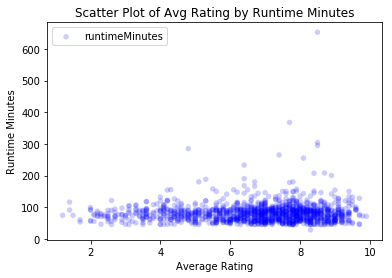

<Figure size 576x432 with 0 Axes>

In [1194]:
plt.title("Scatter Plot of Avg Rating by Runtime Minutes")
thinkplot.Scatter( df_merge.averageRating, df_merge.runtimeMinutes)
thinkplot.Show(xlabel='Average Rating', ylabel='Runtime Minutes')

### 18. Scatterplot of average rating by number of votes

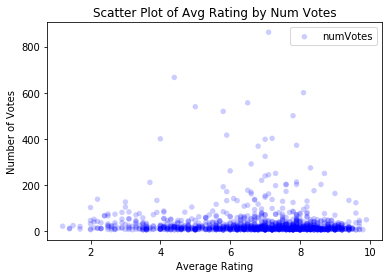

<Figure size 576x432 with 0 Axes>

In [52]:
plt.title("Scatter Plot of Avg Rating by Num Votes")
thinkplot.Scatter( df_merge.averageRating, df_merge.numVotes)
thinkplot.Show(xlabel='Average Rating', ylabel='Number of Votes')

### 19. Testing the Hypothesis: Testing Correlation

In [58]:
runtime = df_merge.runtimeMinutes
rating = df_merge.averageRating

P_Corr = thinkstats2.Corr(runtime,
                          rating)
S_Corr = thinkstats2.SpearmanCorr(runtime, 
                                  rating)


covariance = np.cov(runtime, rating)
print("Covariance:" + str(covariance))
print("Pearson's Correlation:" + str(round(P_Corr,4)))
print("Spearman's Correlation:" + str(round(S_Corr,4)))
print("The correlation is small, but statistically signficant")



Covariance:[[1048.23598628    2.72803575]
 [   2.72803575    3.06394495]]
Pearson's Correlation:0.0481
Spearman's Correlation:0.0153
The correlation is small, but statistically signficant


### 20. Testing the Hypothesis: Classical Hypothesis Testing

- Step 1. Quantify the size of the apparent effect using difference in means

In [60]:
longerMean = df_merge_longer.averageRating.mean()
otherMean = df_merge_other.averageRating.mean()
typicalMean = df_merge.averageRating.mean()
effectSize = longerMean - otherMean

print("Total Data Mean:" +str(round(typicalMean,4)))
print("Longer Data Mean:" +str(round(longerMean,4)))
print("Other Data Mean:" +str(round(otherMean,4)))
print("Difference of Means (Effect Size):" + str(round(effectSize,4)))
print("Effect Percent:" +str(round((effectSize / typicalMean)*100,2))+"%")


Total Data Mean:6.7908
Longer Data Mean:6.9598
Other Data Mean:6.7365
Difference of Means (Effect Size):0.2233
Effect Percent:3.29%


### 21. Testing the Cohen Effect Size
- The Cohen Effect Size is 0.0036, which is considered positive and low

In [73]:
import math
def CohenEffectSize(group1, group2):
    diff = group1.mean() - group2.mean()
    
    var1 = group1.var()
    var2 = group2.var()
    n1, n2 = len(group1), len(group2)
    
    pooled_var = (n1 * var1 * n2 * var2) / (n1 + n2)
    d = diff / math.sqrt(pooled_var)
    return d

allCo =CohenEffectSize(df_merge_longer.averageRating, df_merge.averageRating)
lonCo = CohenEffectSize(df_merge_longer.averageRating, df_merge_other.averageRating)

print(allCo, lonCo)

0.003633269091069647 0.004872118497186696


The p-value is 0.126
We expect to see a difference as big as the observed effect about 12.6% of the time


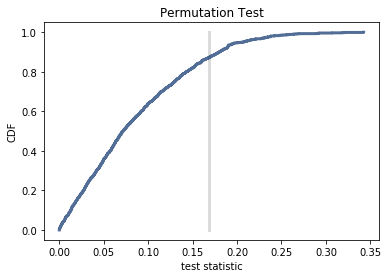

<Figure size 576x432 with 0 Axes>

In [79]:
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
print("The p-value is "+ str(pvalue))
print("We expect to see a difference as big as the observed effect about "+
     str(round((pvalue*100),2))+"% of the time")

plt.title('Permutation Test')
plt.ylabel('CDF')
plt.xlabel('Difference in Means')

ht.PlotCdf()
thinkplot.Show(xlabel="test statistic", ylabel='CDF')




### 22. Linear Regression Analysis

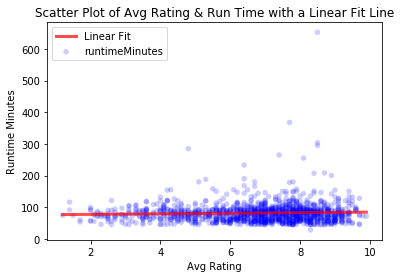

<Figure size 576x432 with 0 Axes>

In [81]:
avgRating = df_merge.averageRating
runtimeMins = df_merge.runtimeMinutes

plt.title('Scatter Plot of Avg Rating & Run Time with a Linear Fit Line')
inter, slope = thinkstats2.LeastSquares(avgRating, runtimeMins)
fit_xs, fit_ys = thinkstats2.FitLine(avgRating, inter, slope)
thinkplot.Scatter(avgRating, runtimeMins)
thinkplot.Plot(fit_xs, fit_ys, label='Linear Fit', color='red')
thinkplot.Show(xlabel='Avg Rating', ylabel='Runtime Minutes')

### 23. Linear Regression Statistics Analysis

In [93]:
from scipy.stats import linregress
result = linregress(avgRating, runtimeMins)
print("Slope: "+str(round(result.slope,3)))
print("Intercept: "+str(round(result.intercept,3)))
print("R Value: "+str(round(result.rvalue,3)))
print("P Value: "+str(round(result.pvalue,3)))
print("Standard Error: "+str(round(result.stderr,3)))



Slope: 0.89
Intercept: 75.372
R Value: 0.048
P Value: 0.08
Standard Error: 0.509


### 24. Slope Test

In [91]:
class SlopeTest(thinkstats2.HypothesisTest):
    """Tests the slope of a linear least squares fit. """

    def TestStatistic(self, data):
        """Computes the test statistic.
        data: data in whatever form is relevant        
        """
        x, y = data
        _, slope = thinkstats2.LeastSquares(x, y)
        return slope

    def MakeModel(self):
        """Builds a model of the null hypothesis.
        """
        _, y = self.data
        self.ybar = y.mean()
        self.res = y - self.ybar

    def RunModel(self):
        """Runs the model of the null hypothesis.
        returns: simulated data
        """
        x, _ = self.data
        y = self.ybar + np.random.permutation(self.res)
        return x, y

print("slope: "+str(thinkstats2.LeastSquares(avgRating, runtimeMins)))
ht = SlopeTest((avgRating, runtimeMins))
pvalue = ht.PValue()
print('p-value, slope test', pvalue)



slope: (75.37234895080618, 0.8903670920546036)
p-value, slope test 0.027


#Since the p-value is less than 0.05, the null hypothesis can be rejected.